In [83]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/lgg-mri-segmentation/kaggle_3m/README.md
/kaggle/input/lgg-mri-segmentation/kaggle_3m/data.csv
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_45.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_56_mask.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_57.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_33.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_27.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_52.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_10.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_8_mask.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_34_mask.tif
/kaggle/input

In [84]:
import os 
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset, DataLoader, Dataset
import torchvision.transforms as transform
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import random


In [85]:
class lggsegmentation(Dataset):
    def __init__(self, data_dir, transform=None):
        self.transform = transform
        self.list = []
        
        for folder in os.listdir(data_dir):
            folder_path = os.path.join(data_dir, folder)
            if not os.path.isdir(folder_path):
                    continue

            for file in os.listdir(folder_path):
                if file.lower().endswith(".tif") and "_mask" not in file:
                    img_path = os.path.join(folder_path, file)
                    mask_path = img_path.replace(".tif", "_mask.tif")
                    self.list.append((img_path, mask_path))

    def __len__(self):
        return len(self.list)

    def __getitem__(self, index):
        img_path, mask_path = self.list[index]

        image = Image.open(img_path).convert("L")  
        mask = Image.open(mask_path).convert("L")   
        image = np.array(image, dtype=np.float32) / 255.0
        mask  = np.array(mask, dtype=np.float32)
        mask[mask > 0] = 1  

        if self.transform is not None:
            augmented = self.transform(image=image, mask=mask)
            image = augmented["image"]
            mask = augmented["mask"]

        return image, mask


In [86]:

train_transform = A.Compose([
    A.Resize(256,256),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(256,256),
    ToTensorV2()
])


In [93]:
# class Unet(nn.Module):
#     def __init__(self, n_classes=1):
#         super(Unet, self).__init__()

#         def doubleconv(in_channels, out_channels):
#             return nn.Sequential(
#                 nn.Conv2d(in_channels, out_channels, 3, padding=1),
#                 nn.BatchNorm2d(out_channels),
#                 nn.ReLU(inplace=True),
#                 nn.Conv2d(out_channels, out_channels, 3, padding=1),
#                 nn.BatchNorm2d(out_channels),
#                 nn.ReLU(inplace=True)
#             )

#         # -------- Encoder --------
#         self.enc1 = doubleconv(1, 64)
#         self.enc2 = doubleconv(64, 128)
#         self.enc3 = doubleconv(128, 256)
#         self.enc4 = doubleconv(256, 512)

#         self.pool = nn.MaxPool2d(2)

#         # -------- Bottleneck --------
#         self.bottleneck = doubleconv(512, 1024)

#         # -------- Decoder --------
#         self.up4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
#         self.dec4 = doubleconv(1024, 512)

#         self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
#         self.dec3 = doubleconv(512, 256)

#         self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
#         self.dec2 = doubleconv(256, 128)

#         self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
#         self.dec1 = doubleconv(128, 64)

#         # -------- Output --------
#         self.out = nn.Conv2d(64, n_classes, kernel_size=1)

#     def forward(self, x):
#         # -------- Encoder --------
#         e1 = self.enc1(x)
#         e2 = self.enc2(self.pool(e1))
#         e3 = self.enc3(self.pool(e2))
#         e4 = self.enc4(self.pool(e3))

#         # -------- Bottleneck --------
#         b = self.bottleneck(self.pool(e4))

#         # -------- Decoder --------
#         d4 = self.up4(b)
#         d4 = torch.cat([d4, e4], dim=1)
#         d4 = self.dec4(d4)

#         d3 = self.up3(d4)
#         d3 = torch.cat([d3, e3], dim=1)
#         d3 = self.dec3(d3)

#         d2 = self.up2(d3)
#         d2 = torch.cat([d2, e2], dim=1)
#         d2 = self.dec2(d2)

#         d1 = self.up1(d2)
#         d1 = torch.cat([d1, e1], dim=1)
#         d1 = self.dec1(d1)

#         return self.out(d1)


In [108]:
class Unet3Layers(nn.Module):
    def __init__(self, n_classes=1):
        super(Unet3Layers, self).__init__()

        def doubleconv(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, 3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )

        # -------- Encoder --------
        self.enc1 = doubleconv(1, 64)
        self.enc2 = doubleconv(64, 128)
        self.enc3 = doubleconv(128, 256)

        self.pool = nn.MaxPool2d(2)

        # -------- Bottleneck --------
        self.bottleneck = doubleconv(256, 512)

        # -------- Decoder --------
        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = doubleconv(512, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = doubleconv(256, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = doubleconv(128, 64)

        # -------- Output --------
        self.out = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        # -------- Encoder --------
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))

        # -------- Bottleneck --------
        b = self.bottleneck(self.pool(e3))

        # -------- Decoder --------
        d3 = self.up3(b)
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.dec3(d3)

        d2 = self.up2(d3)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)

        d1 = self.up1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)

        return self.out(d1)


In [88]:
full_dataset = lggsegmentation(
    data_dir="/kaggle/input/lgg-mri-segmentation/kaggle_3m",
    transform=None
)

indices = list(range(len(full_dataset)))
train_idx, val_idx = train_test_split(indices, test_size=0.2, random_state=42)

train_dataset = lggsegmentation(
    data_dir="/kaggle/input/lgg-mri-segmentation/kaggle_3m",
    transform=train_transform
)
val_dataset = lggsegmentation(
    data_dir="/kaggle/input/lgg-mri-segmentation/kaggle_3m",
    transform=val_transform
)

train_dataset = Subset(train_dataset, train_idx)
val_dataset   = Subset(val_dataset, val_idx)

#
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=8, shuffle=False)


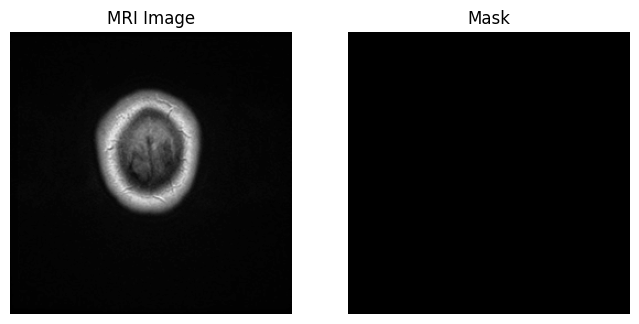

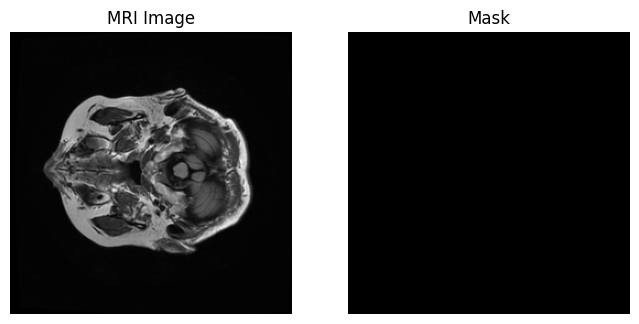

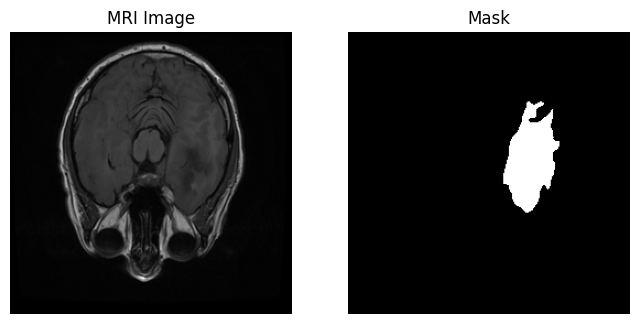

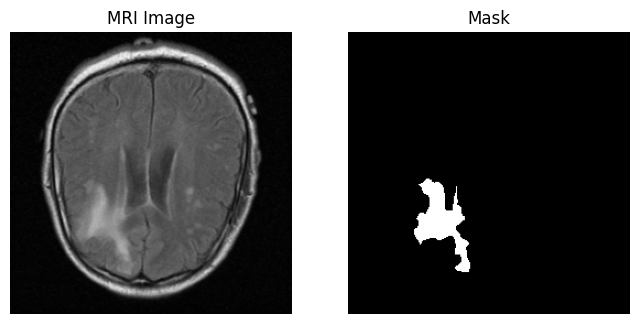

In [107]:
images, masks = next(iter(train_loader))  

for i in range(4):   
    img = images[i].squeeze().cpu().numpy()
    msk = masks[i].squeeze().cpu().numpy()

    plt.figure(figsize=(8,4))

    plt.subplot(1,2,1)
    plt.imshow(img, cmap="gray")
    plt.title("MRI Image")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(msk, cmap="gray")
    plt.title("Mask")
    plt.axis("off")

    plt.show()


In [90]:
def dice_score(preds, targets, smooth=1e-6):
    preds = preds.contiguous().view(-1)
    targets = targets.contiguous().view(-1)
    
    intersection = (preds * targets).sum()
    dice = (2. * intersection + smooth) / (preds.sum() + targets.sum() + smooth)
    return dice.item()

def iou_score(preds, targets, smooth=1e-6):
    preds = preds.contiguous().view(-1)
    targets = targets.contiguous().view(-1)

    intersection = (preds * targets).sum()
    union = preds.sum() + targets.sum() - intersection

    iou = (intersection + smooth) / (union + smooth)
    return iou.item()


In [109]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = Unet3Layers(n_classes=1).to(device)

criterion = nn.BCEWithLogitsLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [111]:
epochs = 25
for epoch in range(epochs):
    model.train()
    train_loss, train_dice, train_iou = 0.0, 0.0, 0.0
    
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device).float()
        
        output = model(images)
        loss = criterion(output, masks.unsqueeze(1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pred = (torch.sigmoid(output) > 0.5).float()
        train_dice += dice_score(pred, masks.unsqueeze(1))
        train_iou  += iou_score(pred, masks.unsqueeze(1))
        train_loss += loss.item()

    # ----------------- Validation -----------------
    model.eval()
    val_loss, val_dice, val_iou = 0.0, 0.0, 0.0
    
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device).float()

            output = model(images)
            loss = criterion(output, masks.unsqueeze(1))

            pred = (torch.sigmoid(output) > 0.5).float()
            val_dice += dice_score(pred, masks.unsqueeze(1))
            val_iou  += iou_score(pred, masks.unsqueeze(1))
            val_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}] "
          f"Train Loss: {train_loss/len(train_loader):.4f} "
          f"Val Loss: {val_loss/len(val_loader):.4f} "
          f"Train Dice: {train_dice/len(train_loader):.4f} "
          f"Val Dice: {val_dice/len(val_loader):.4f} "
          f"Train IoU: {train_iou/len(train_loader):.4f} "
          f"Val IoU: {val_iou/len(val_loader):.4f}")


Epoch [1/25] Train Loss: 0.1009 Val Loss: 0.0844 Train Dice: 0.0358 Val Dice: 0.0404 Train IoU: 0.0357 Val IoU: 0.0404
Epoch [2/25] Train Loss: 0.0710 Val Loss: 0.0638 Train Dice: 0.0353 Val Dice: 0.0472 Train IoU: 0.0311 Val IoU: 0.0439
Epoch [3/25] Train Loss: 0.0556 Val Loss: 0.0513 Train Dice: 0.2206 Val Dice: 0.2341 Train IoU: 0.1544 Val IoU: 0.1598
Epoch [4/25] Train Loss: 0.0468 Val Loss: 0.0484 Train Dice: 0.2687 Val Dice: 0.2077 Train IoU: 0.1813 Val IoU: 0.1375
Epoch [5/25] Train Loss: 0.0402 Val Loss: 0.0406 Train Dice: 0.3359 Val Dice: 0.4022 Train IoU: 0.2303 Val IoU: 0.2712
Epoch [6/25] Train Loss: 0.0341 Val Loss: 0.0328 Train Dice: 0.4145 Val Dice: 0.4533 Train IoU: 0.2899 Val IoU: 0.3195
Epoch [7/25] Train Loss: 0.0290 Val Loss: 0.0271 Train Dice: 0.4785 Val Dice: 0.5209 Train IoU: 0.3480 Val IoU: 0.3816
Epoch [8/25] Train Loss: 0.0249 Val Loss: 0.0257 Train Dice: 0.5390 Val Dice: 0.5655 Train IoU: 0.4037 Val IoU: 0.4271
Epoch [9/25] Train Loss: 0.0236 Val Loss: 0.0215

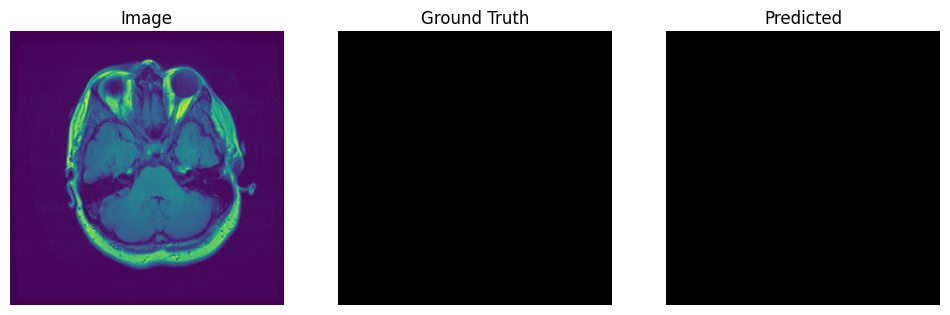

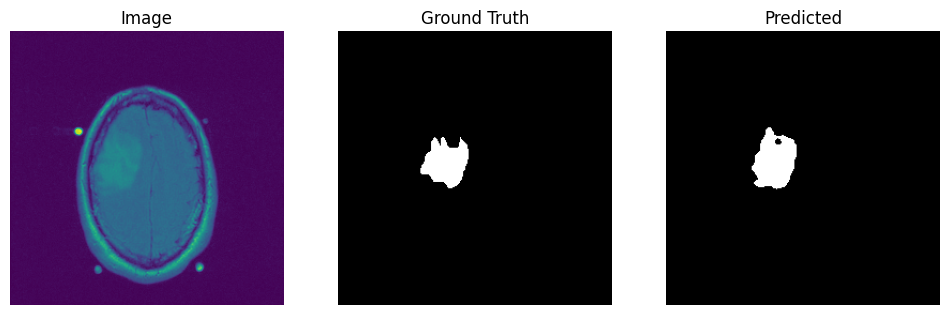

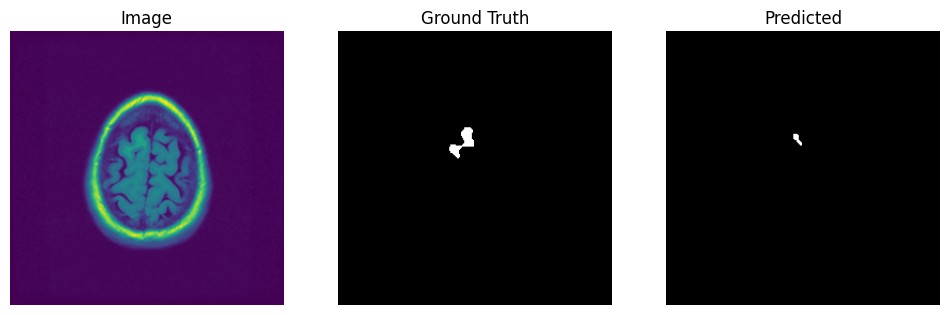

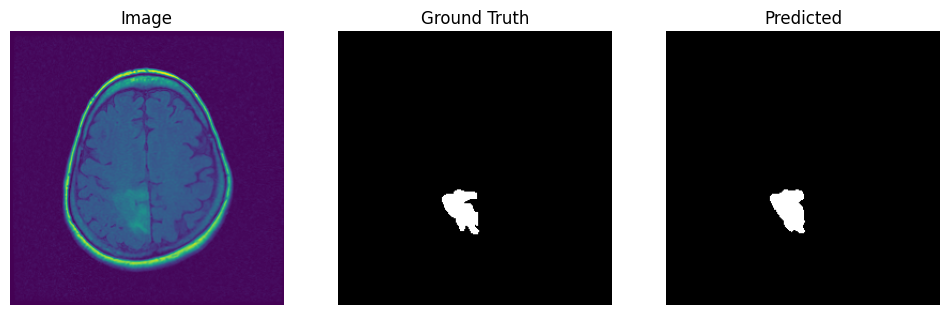

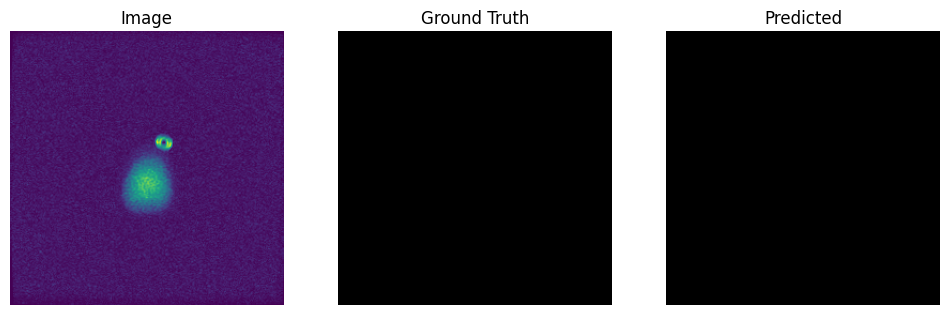

In [120]:
def show_results(model, dataset, device, num_samples=3):
    model.eval()
    
    indices = random.sample(range(len(dataset)), num_samples)
    
    for i in indices:
        image, mask = dataset[i]
        input_tensor = image.unsqueeze(0).to(device)  # شكل (1,C,H,W)
        mask = mask.numpy()

        with torch.no_grad():
            output = model(input_tensor)
            pred = torch.sigmoid(output)
            pred = (pred > 0.5).float().cpu().squeeze().numpy()

        img_show = image.permute(1,2,0).numpy()

        plt.figure(figsize=(12,4))
        plt.subplot(1,3,1)
        plt.imshow(img_show)
        plt.title("Image")
        plt.axis("off")

        plt.subplot(1,3,2)
        plt.imshow(mask, cmap="gray")
        plt.title("Ground Truth")
        plt.axis("off")

        plt.subplot(1,3,3)
        plt.imshow(pred, cmap="gray")
        plt.title("Predicted")
        plt.axis("off")

        plt.show()

# دلوقتي نعرض 5 صور عشوائية
show_results(model, val_dataset, device, num_samples=5)


In [127]:
import matplotlib.pyplot as plt

def plot_training_curves(train_loss, val_loss, train_dice, val_dice, train_iou, val_iou):
    epochs = range(1, len(train_loss)+1)

    plt.figure(figsize=(18,5))
    
    # ---------- Loss ----------
    plt.subplot(1,3,1)
    plt.plot(epochs, train_loss, 'b-o', label='Train Loss')
    plt.plot(epochs, val_loss, 'r-o', label='Validation Loss')
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    
    # ---------- Dice ----------
    plt.subplot(1,3,2)
    plt.plot(epochs, train_dice, 'b-o', label='Train Dice')
    plt.plot(epochs, val_dice, 'r-o', label='Validation Dice')
    plt.title("Dice Score")
    plt.xlabel("Epochs")
    plt.ylabel("Dice")
    plt.legend()
    
    # ---------- IoU ----------
    plt.subplot(1,3,3)
    plt.plot(epochs, train_iou, 'b-o', label='Train IoU')
    plt.plot(epochs, val_iou, 'r-o', label='Validation IoU')
    plt.title("IoU Score")
    plt.xlabel("Epochs")
    plt.ylabel("IoU")
    plt.legend()
    
    plt.tight_layout()
    plt.show()


In [129]:
# بعد ما خلصت التدريب
# train_loss_list, val_loss_list, train_dice_list, val_dice_list, train_iou_list, val_iou_list

plot_training_curves(
    train_loss, val_loss, train_dice, val_dice, train_iou, val_iou
)


TypeError: object of type 'float' has no len()